# Chapter 18 Splines and Piecewise Interpolation

### Cubic splines
$$ a = x_0 < x_1 < \cdots < x_n = b$$
for $x_j < x < x_{j+1}$, 
$$ p_j(x_j) = f_j, \quad p_j(x_{j+1}) = f_{j+1} \quad ( j=0, 1, 2, \cdots, n-1 )$$

$$ p'_j (x_j) = k_j, \quad p'_j(x_{j+1}) = k_{j+1}  $$

$$c_j = \frac{1}{x_{j+1} - x_j}$$

where $k_0$ and $k_n$ are given (clamp end), and $k_1, \cdots, k_{n-1}$ will be determined

$$\begin{equation} \begin{split}
p_j(x) & = f_j c_j^2 (x-x_{j+1})^2 [1 + 2 c_j (x - x_j)] \\
       & \quad + f_{j+1} c_j^2 (x-x_j)^2 [1 - 2 c_j (x-x_{j+1})] \\
       & \quad + k_j c_j^2 (x-x_j)(x-x_{j+1})^2 \\
       & \quad + k_{j+1} c_j^2 (x-x_j)^2 (x-x_{j+1})       
\end{split}       
\end{equation}$$

Differentiating twice

$$ p''_j(x_j) = -6 c_j^2 f_j + 6 c_j^2 f_{j+1} - 4 c_j k_j - 2c_j k_{j+1}$$

$$ p''_j(x_{j+1}) = 6 c_j^2 f_j - 6 c_j^2 f_{j+1} + 2 c_j k_j + 4c_j k_{j+1}$$

continuous second derivatives

$$ p''_{j-1} (x_j) = p''_j(x_j)$$

$$c_{j-1} k_{j-1} + 2 (c_{j-1} + c_j) k_j + c_j k_{j+1} = 3 [c_{j-1}^2 \nabla f_j + c_j^2 \nabla f_{j+1}  ] $$
$$ \nabla f_j = f_j - f_{j-1}$$

For $x_j < x < x_{j+1} = x_j + h$

$$\begin{equation} \begin{split}
p(x) & = a_{0} + a_{1} (x-x_j) + a_{2} (x-x_j)^2  + a_{3} (x-x_j)^3 \\
a_{0} & = p(x_j) = f_j \\
a_{1} & = p'(x_j) = k_j \\
a_{2} & = \frac{1}{2} p''(x_j) = \frac{3}{h^2} (f_{j+1}-f_j) - \frac{1}{h}(k_{j+1} + 2k_j) \\
a_{3} & = \frac{1}{6} p'''(x_j) = \frac{2}{h^3} (f_{j}-f_{j+1}) + \frac{1}{h^2}(k_{j+1} + k_j) 
\end{split} \end{equation}$$

$$\begin{equation} \begin{split}
p(x)    & = a_{0} + a_{1} (x-x_j) + a_{2} (x-x_j)^2  + a_{3} (x-x_j)^3 \\
p'(x)   & = a_1 + 2 a_2 (x-x_j) + 3 a_3 (x-x_j)^2 \\ 
p''(x)  & = 2 a_2  + 6 a_3 (x-x_j) \\ 
p'''(x) & = 6 a_3
\end{split} \end{equation}$$


In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
def tdma(tri):
    # tri-diagonal system
    e, f, g, r = tri.T
    n = len(f)
    for k in range(1, n):
        factor = e[k] / f[k - 1]
        f[k]  -= factor * g[k - 1]
        r[k]  -= factor * r[k - 1]
    x = np.zeros_like(f)
    x[-1] = r[-1] / f[-1]
    for k in reversed(range(n - 1)):
        x[k] = (r[k] - g[k] * x[k+1]) / f[k]
    return x

In [3]:
def spline_rep(x, f, k1=None, kn=None):
    n, c, df = len(x), 1/np.diff(x), np.diff(f)
    tri = np.zeros((n, 4))    
    for j in range(1, n-1):
        tri[j] = [c[j-1], 2*(c[j-1] + c[j]), c[j], 
            3*(c[j-1]**2*df[j-1] + c[j]**2*df[j])]
    if k1 == None: # natural 
        tri[0]  = [  0,  2, 1, -3*c[0]*f[ 0] + 3*c[ 0]*f[ 1] ]    
    else:          # clamp
        tri[0]  = [0, 1, 0, k1]
    if kn == None: # natural 
        tri[-1] = [ -1, -2, 0, 3*c[-1]*f[-2] - 3*c[-1]*f[-1] ]
    else:          # clamp
        tri[-1] = [0, 1, 0, kn]
    
    k = tdma(tri)    
    return np.array([x, f, k])

In [4]:
def find_segment(knot, x):
    ileft, iright = 0, len(knot) - 1
    while 1:
        if iright - ileft <= 1: 
            return ileft
        i = (ileft + iright) // 2
        if x < knot[i]: 
            iright = i
        else:
            ileft = i
        
def _spline_eval(z, tck):
    x, f, k = tck
    j = find_segment(x, z)
    h = x[j+1] - x[j]
    a = np.array([ f[j], k[j],
            3/h**2*(f[j+1] - f[j]) - 1/h*(k[j+1]    + 2*k[j]),
            2/h**3*(f[j] - f[j+1]) + 1/h**2*(k[j+1] + k[j]) ])
    z = z - x[j]
    p0 = a[0] + a[1]*z + a[2]*z**2 + a[3]*z**3
    p1 = a[1] + 2*a[2]*z + 3*a[3]*z**2
    p2 = 2*a[2] + 6*a[3]*z
    p3 = 6*a[3]
    return np.array([p0, p1, p2, p3])

def spline_eval(z, tck, degree=None):    
    if np.isscalar(z):
        res = _spline_eval(z, tck)
        if degree==None: return res
        else:            return res[degree]
    else:
        res = np.array([_spline_eval(z1, tck) for z1 in z])
        if degree==None: return res
        else:            return res[:,degree]

### Example 
Interpolate $f(x) = x^4$ on the interval $-1 < x < 1$ by the cubic spline corresponding to the partition $x_0 = -1, x_1 = 0, x_2 = 1$ and satisfying the clamped conditions $g'(-1) = f'(-1), g'(1) = f'(1)$.

[-4.00000000e+00 -2.04800000e+00 -8.64000000e-01 -2.56000000e-01
 -3.20000000e-02 -2.97482836e-18  3.20000000e-02  2.56000000e-01
  8.64000000e-01  2.04800000e+00  4.00000000e+00]


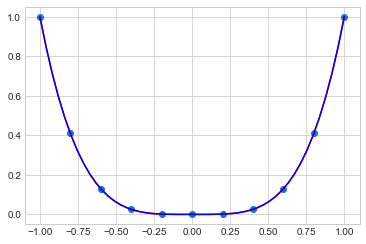

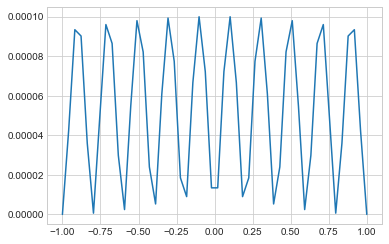

In [8]:
# x = np.array([-1, 0, 1])
x = np.linspace(-1, 1, 11)
f = x**4
k1 = 4*(-1)**3
kn = 4*(1)**3
xfk = spline_rep(x, f, k1, kn)
print(xfk[2])

xx = np.linspace(-1.0, 1.0)
ff = xx**4
ff_a = spline_eval(xx, xfk, 0)
plt.plot(x, f, 'o')
plt.plot(xx, ff, 'r')
plt.plot(xx, ff_a, 'b')
plt.show()

plt.plot(xx, ff-ff_a)
plt.show()

### Example 18.4

In [10]:
def fun(x):
    return 1.0 / (1.0 + 25.0 * x**2)

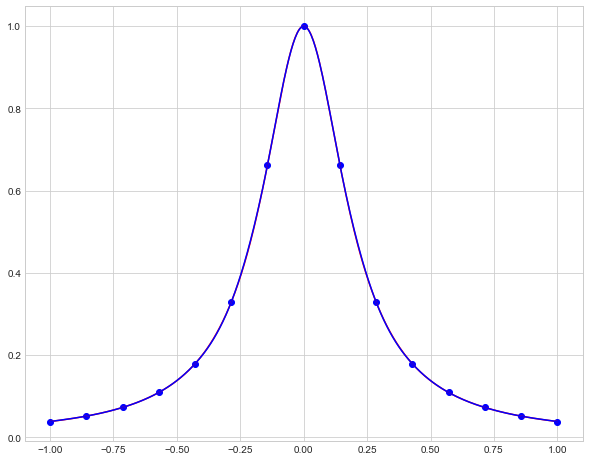

In [12]:
plt.figure(figsize=(10, 8))

n = 15
x = np.linspace(-1, 1, n)
y = fun(x)
plt.plot(x,y, 'bo', label='data')

xs = np.linspace(-1, 1, 500)
ys = fun(xs)
plt.plot(xs, ys, 'r')

# p = np.polyfit(x, y, n-1)
# ys = np.polyval(p, xs)
# plt.plot(xs, ys, 'g')

xfk = spline_rep(x, y)
ys = spline_eval(xs, xfk, 0)
plt.plot(xs, ys, 'b');

### Case Study 18.7 Heat Transfer

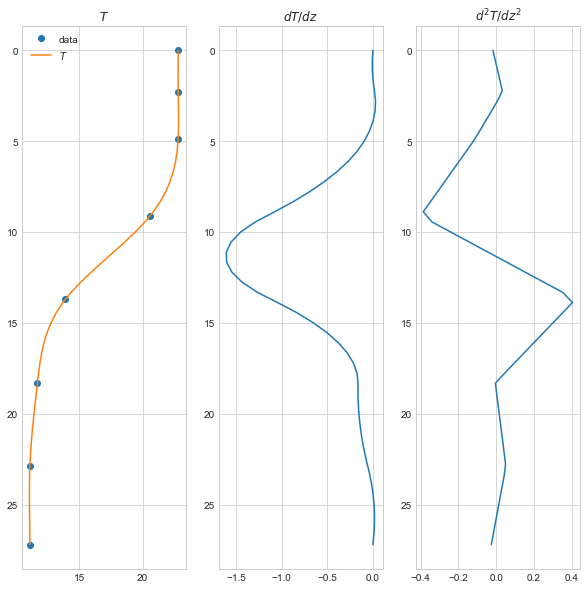

deflection point       1.00 m
temperature            0.04 C
temp. gradient        -0.06 C/m
heat flux             -0.54 cal/cm^2-day


In [8]:
z = np.array([ 0.0,  2.3,  4.9,  9.1, 13.7, 18.3, 22.9, 27.2])
T = np.array([22.8, 22.8, 22.8, 20.6, 13.9, 11.7, 11.1, 11.1])

tck = spline_rep(z, T, 0, 0) 

zs = np.linspace(z[0], z[-1])
TT = spline_eval(zs, tck)

plt.figure(figsize= (10, 10))

plt.subplot(1,3,1)
plt.gca().invert_yaxis()
plt.plot(T, z, 'o', label='data')

plt.plot(TT[:,0], zs, label=r'$T$')
plt.title(r'$T$')
plt.legend()

plt.subplot(1,3,2)
plt.gca().invert_yaxis()
plt.plot(TT[:,1], zs)
plt.title(r'$dT/dz$')

plt.subplot(1,3,3)
plt.gca().invert_yaxis()
plt.plot(TT[:,2], zs)
plt.title(r'$d^2T/dz^2$')

plt.show()

from scipy.optimize import newton
zc = newton(lambda zc: spline_eval(zc, xfk, 2), 12)
Tc, dTc = spline_eval(zc, xfk)[:2]

alpha, rho, C = 0.01, 1, 1
flux = alpha*(60*60*24)*rho*C*dTc/100
print('deflection point %10.2f m' % zc)
print('temperature      %10.2f C' % Tc)
print('temp. gradient   %10.2f C/m' % dTc)
print('heat flux        %10.2f cal/cm^2-day' % flux)

### Python interpolate

**scipy.interpolate.splrep**
- Given the set of data points (x[i], y[i]) determine a smooth spline approximation of degree k on the interval

**scipy.interpolate.splev**
- Given the knots and coefficients of a B-spline representation, evaluate the value of the smoothing polynomial and its derivatives.

**scipy.interpolate.spalde**
- Given the knots and coefficients of a cubic B-spline compute all derivatives up to order k at a point (or set of points).

### Case Study 18.7 Heat Transfer

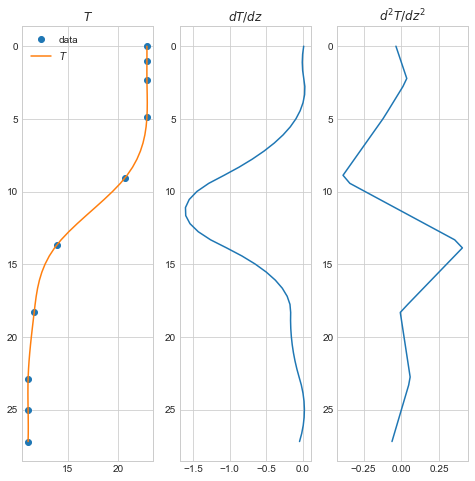

deflection point      11.34 m
temperature           17.31 C
temp. gradient        -1.61 C/m
heat flux            -13.95 cal/cm^2-day


In [9]:
from scipy.interpolate import splrep, splev

z = np.array([0, 1, 2.3, 4.9, 9.1, 13.7, 18.3, 22.9, 25, 27.2])
T = np.array([22.8, 22.8, 22.8, 22.8, 20.6, 13.9, 11.7, 11.1, 11.1, 11.1])

tck = splrep(z, T)
zs = np.linspace(0, 27.2)

plt.figure(figsize= (8, 8))

plt.subplot(1,3,1)
plt.gca().invert_yaxis()
plt.plot(T, z, 'o', label='data')
plt.plot(splev(zs, tck, 0), zs, label=r'$T$')
plt.title(r'$T$')
plt.legend()

plt.subplot(1,3,2)
plt.gca().invert_yaxis()
plt.plot(splev(zs, tck, 1), zs)
plt.title(r'$dT/dz$')

plt.subplot(1,3,3)
plt.gca().invert_yaxis()
plt.plot(splev(zs, tck, 2), zs)
plt.title(r'$d^2T/dz^2$')

plt.show()

from scipy.optimize import bisect
fun = lambda z: splev(z, tck, 2)
zc = bisect(fun, 5, 15)
T = splev(zc, tck, 0)
dT = splev(zc, tck, 1)

alpha, rho, C = 0.01, 1, 1
flux = alpha*(60*60*24)*rho*C*dT/100
print('deflection point %10.2f m' % zc)
print('temperature      %10.2f C' % T)
print('temp. gradient   %10.2f C/m' % dT)
print('heat flux        %10.2f cal/cm^2-day' % flux)